In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
dataset_path = "Data/creditcard.csv"
df = pd.read_csv(dataset_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset_array = df.to_numpy()
X, y= dataset_array[:,:-1].astype(np.float64), dataset_array[:,-1].astype(np.uint8)

In [5]:
# Thêm bias
intercept = np.ones((X.shape[0],1))

X_b =  np.concatenate((intercept, X), axis = 1)

In [6]:
n_classes = np.unique(y, axis =0).shape[0]
n_samples = y.shape[0]

y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

In [7]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

# Chia dữ liệu thành tập huấn luyện và tập validation
X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

# Chia tập huấn luyện thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [9]:
normalizer = StandardScaler()
X_train[:,1:] = normalizer.fit_transform(X_train[:,1:])
X_val[:,1:] = normalizer.transform(X_val[:,1:])
X_test[:,1:] = normalizer.transform(X_test[:,1:])

In [10]:
# cài đặt các hàm quan trọng
def softmax(z):
    exp_z = np.exp(z)

    return exp_z/exp_z.sum(axis=1)[:,None]

def predict(X,theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)

    return y_hat

def compute_loss(y_hat, y):
    n= y.size

    return (-1/n)*np.sum(y*np.log(y_hat))

def compute_gradient(X,y, y_hat):
    n = y.size

    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr):
    return theta - lr*gradient

def compute_accuracy(X, y,  theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat,axis =1) == np.argmax(y, axis =1)).mean()

    return acc

In [11]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train . shape [1]

np.random.seed(random_state)
theta = np.random.uniform(size =( n_features , n_classes ))

In [12]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)
        train_acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(train_acc)

    # Validation
    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)
    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1:	Training loss: 0.300	Validation loss: 0.222

EPOCH 2:	Training loss: 0.176	Validation loss: 0.137

EPOCH 3:	Training loss: 0.115	Validation loss: 0.094

EPOCH 4:	Training loss: 0.081	Validation loss: 0.069

EPOCH 5:	Training loss: 0.062	Validation loss: 0.054

EPOCH 6:	Training loss: 0.049	Validation loss: 0.044

EPOCH 7:	Training loss: 0.041	Validation loss: 0.037

EPOCH 8:	Training loss: 0.035	Validation loss: 0.033

EPOCH 9:	Training loss: 0.031	Validation loss: 0.029

EPOCH 10:	Training loss: 0.028	Validation loss: 0.026

EPOCH 11:	Training loss: 0.025	Validation loss: 0.024

EPOCH 12:	Training loss: 0.023	Validation loss: 0.022

EPOCH 13:	Training loss: 0.021	Validation loss: 0.020

EPOCH 14:	Training loss: 0.020	Validation loss: 0.019

EPOCH 15:	Training loss: 0.019	Validation loss: 0.018

EPOCH 16:	Training loss: 0.017	Validation loss: 0.017

EPOCH 17:	Training loss: 0.017	Validation loss: 0.016

EPOCH 18:	Training loss: 0.016	Validation loss: 0.015

EPOCH 19:	Training

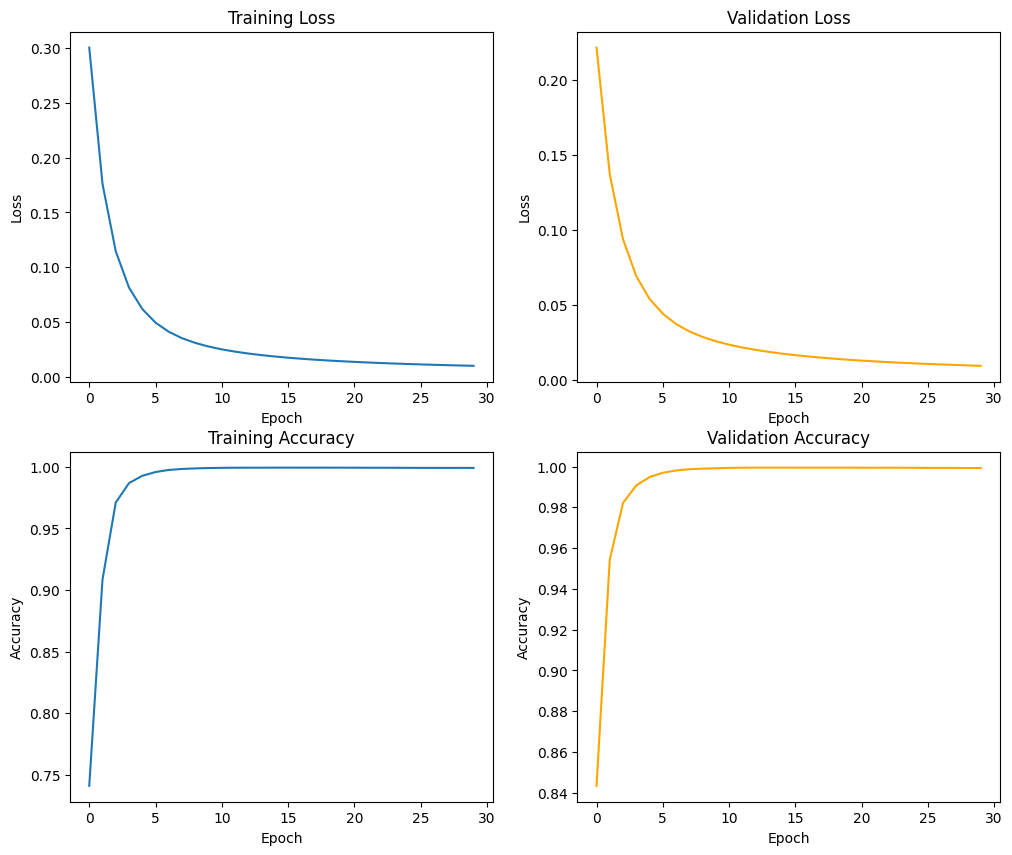

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


In [14]:
val_set_acc = compute_accuracy (X_val , y_val , theta )
test_set_acc = compute_accuracy ( X_test , y_test , theta )
print('Evaluation on validation and test set :')
print(f'Accuracy : { val_set_acc }')
print(f'Accuracy : { test_set_acc }')

Evaluation on validation and test set :
Accuracy : 0.9993153330290369
Accuracy : 0.9992275552122467
